                                  OLS Regression Results                                 
Dep. Variable:     ia_bandwidth_per_student_kbps   R-squared:                       0.002
Model:                                       OLS   Adj. R-squared:                  0.002
Method:                            Least Squares   F-statistic:                     3.004
Date:                           Thu, 04 May 2017   Prob (F-statistic):            0.00139
Time:                                   16:20:12   Log-Likelihood:            -1.2295e+05
No. Observations:                          11505   AIC:                         2.459e+05
Df Residuals:                              11495   BIC:                         2.460e+05
Df Model:                                      9                                         
Covariance Type:                       nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
---

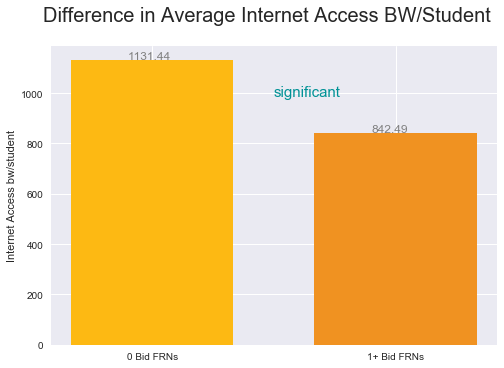

Residuals QQ-Plot


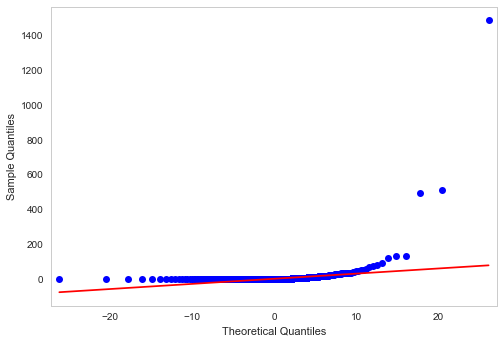

Error: Singular covariance matrix, Harvey Collier nonlinearity test not executed


In [1]:
import sys
sys.modules[__name__].__dict__.clear()

##packages
import matplotlib.pyplot as plt
import pylab
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import sys
import os
sys.path.append(os.path.abspath('/Users/sierra/Documents/ESH/ficher/General_Resources/common_functions'))

## data prep
#import
districts_for_ia_bw_reg = pd.read_csv('../../data/interim/reg/districts_for_sc_reg.csv',index_col=0)
#clean for cost only for regression
districts_for_ia_bw_reg = districts_for_ia_bw_reg.loc[districts_for_ia_bw_reg['exclude_from_ia_analysis'] == False]
#aggregate 2+,3+
districts_for_ia_bw_reg['frns_2p_bid_ia_indicator']  = np.where(np.logical_or(districts_for_ia_bw_reg['frns_2_bid_ia_indicator'] == True, districts_for_ia_bw_reg['frns_3p_bid_ia_indicator'] == True), True, False)
#add factor for if state procures independently - https://docs.google.com/document/d/1dXYTiRystJK_SfM9pO3ZBrsOYRIUhON-nWs169Oigr8/
state_procures_independently = ['AK', 'AZ', 'CT', 'CO', 'FL', 'ID', 'IL', 'IN', 'KS', 'LA', 'MA', 'MD', 'MT', 'NH', 'NJ', 'NM', 'NV', 'OK', 'TN', 'VA', 'VT']
districts_for_ia_bw_reg['state_procures_independently'] = districts_for_ia_bw_reg['postal_cd'].isin(state_procures_independently)

## modeling prep
locale_dummies = pd.get_dummies(districts_for_ia_bw_reg.locale, prefix='locale')
#.iloc[:, 1:]
districts_for_ia_bw_reg = pd.concat([districts_for_ia_bw_reg, locale_dummies], axis=1)

type_dummies = pd.get_dummies(districts_for_ia_bw_reg.district_type, prefix='type')
#.iloc[:, 1:]
districts_for_ia_bw_reg = pd.concat([districts_for_ia_bw_reg, type_dummies], axis=1)

#add overall ia bandwidth as cost factor
feature_cols_ia_bw = ['frns_0_bid_ia_indicator', 'frns_1_bid_ia_indicator', 'frns_2p_bid_ia_indicator', 'locale_Rural', 'locale_Suburban', 'locale_Town', 'state_procures_independently', 'num_students', 'type_Charter']


X_ia_bw = districts_for_ia_bw_reg[feature_cols_ia_bw ]
y_ia_bw = districts_for_ia_bw_reg.ia_bandwidth_per_student_kbps

data_true_bw = districts_for_ia_bw_reg.loc[districts_for_ia_bw_reg['frns_2p_bid_ia_indicator'] == True]
data_true_bw = data_true_bw.ia_bandwidth_per_student_kbps

data_false_bw = districts_for_ia_bw_reg.loc[districts_for_ia_bw_reg['frns_2p_bid_ia_indicator'] == False]
data_false_bw = data_false_bw.ia_bandwidth_per_student_kbps

data_true_bw_0 = districts_for_ia_bw_reg.loc[districts_for_ia_bw_reg['frns_0_bid_ia_indicator'] == True]
data_true_bw_0 = data_true_bw_0.ia_bandwidth_per_student_kbps

data_false_bw_0 = districts_for_ia_bw_reg.loc[districts_for_ia_bw_reg['frns_0_bid_ia_indicator'] == False]
data_false_bw_0 = data_false_bw_0.ia_bandwidth_per_student_kbps


## statsmodels model
X_ia_bw = sm.add_constant(X_ia_bw)
est_ia_bw = sm.OLS(y_ia_bw, X_ia_bw.astype(float)).fit()
print(est_ia_bw.summary())

## t test
ttest_ia_bw  = scipy.stats.ttest_ind(data_true_bw, data_false_bw, equal_var=False)
print ttest_ia_bw
print("Fail to reject null hypothesis; districts that receive 2+ bids on one of their internet access services have similar bw/student as districts with only 0, 1 bid internet access services. P-value: {}".format(round(ttest_ia_bw.pvalue,2)))
print("Mean bw/student for districts that receive 2+ bids on one of their internet access services: {}".format(round(np.mean(data_true_bw),2)))
print("Mean bw/student for districts that receive 0, 1 bids on all of their internet access services: {}".format(round(np.mean(data_false_bw),2)))


ttest_ia_bw_0  = scipy.stats.ttest_ind(data_true_bw_0, data_false_bw_0, equal_var=False)
print ttest_ia_bw_0
#p-value divided by 2 for a one-tailed test (since we want to see if 0 bids are significantly GREATER THAN non-0 bids
pvalue = round(ttest_ia_bw_0.pvalue/2,2)
mu_true = round(np.mean(data_true_bw_0),2)
mu_false = round(np.mean(data_false_bw_0),2)
mu_multiple = round(np.mean(data_true_bw_0)/np.mean(data_false_bw_0),1)

print("Reject null hypothesis; districts that receive 0 bids on one of their internet access services have more bw/student than districts with only 1+ bid internet access services. P-value: {}".format(pvalue))
print("Mean bw/student for districts that receive 0 bids on one of their internet access services: {}".format(mu_true))
print("Mean bw/student for districts that receive 1+ bids on all of their internet access services: {}".format(mu_false))


##plot cost/mbps
import seaborn
import os
y = [mu_true, mu_false]
x = [1, 2]
axis_label = ['0 Bid FRNs', '1+ Bid FRNs']
width = 1/1.5

plt.bar(x, y, width, color=["#FDB913","#F09221"], align = 'center')
plt.suptitle('Difference in Average Internet Access BW/Student', fontsize = 20)
plt.xticks(x, axis_label)
plt.ylabel('Internet Access bw/student')
plt.annotate(str(mu_true), xy=(.9, mu_true + 4), xytext=(.9, mu_true + 4), color = "grey")
plt.annotate(str(mu_false), xy=(1.9, mu_false + 4), xytext=(1.9, mu_false + 4), color = "grey")
plt.annotate("significant", xy=(1.5, (mu_true - mu_false)/2 + mu_false), xytext=(1.5, (mu_true - mu_false)/2 + mu_false), color = '#009296', size = 15)
seaborn.despine(left=True, right=True)
seaborn.set_style("whitegrid", {'axes.grid' : False})
plt.savefig('ia_bw_by_frn_bids.png')
plt.show()

##Model diagnostics
import statsmodels_ols_diagnostics as smd
%matplotlib inline
smd.ols_model_diagnostics(est_ia_bw)

#will run only if using ipython notebook
import __main__ as main
import ipynb_convert 
ipynb_convert.executeConvertNotebook('regression_ia_bw.ipynb','regression_ia_bw_qa.py',main)